## Import packages

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [5]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [10]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts.reshape(len(log10masses) - 1, len(z_min))

## (Mock) data for galaxy cluster counts

$\mathcal{N}\left(\Delta M_{500}, \Delta z_{i}\right)=\Omega_{s} \int_{z_{i, \min }}^{z_{i, \max }} \mathrm{d} z \frac{c}{H(z)} \frac{\mathrm{d} V}{\mathrm{d} \chi} \int \mathrm{d} M \frac{\mathrm{d} n}{\mathrm{d} M}$

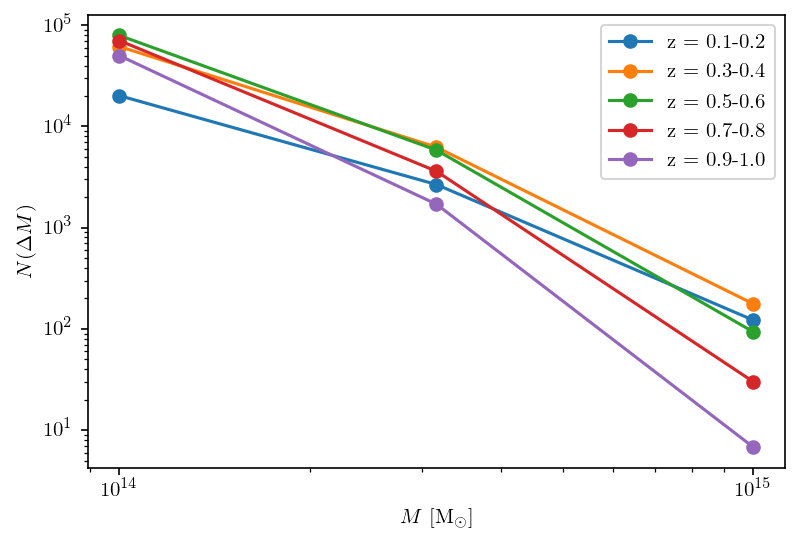

In [7]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
for j in range(len(z_min)):
    plt.plot(10**log10masses[:-1], N_counts[:, j], c=color_map(j), marker = 'o', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')

## Set up priors on params of interest (for now): {$\Omega_{cdm}h^{2}$, $\sigma_{8}$} and define their fiducial values

In [8]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [9]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In this case, simulations are just draws from Poisson distribution of data with means computed using the formula for $\Delta N(M)$ above.

In [10]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

The data is not high-dimensional and not particularly complex, so compressor just returns data itself

In [11]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [12]:
N_counts_data =  N_countsSimulator.N_counts

In [13]:
n_params = len(theta_fiducial)
n_data_points = len(N_counts_data)

## Define ensemble of NDEs

In this case, an ensemble of 3 NDEs (2 MDNs and a MAF) is used. 

In [16]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
        ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2)]



## Create DELFI object

In [19]:
DelfiEnsemble = delfi.Delfi(N_counts_data, prior, NDEs, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results_tinker_2params_1000sims/")



## Sequential Neural Likelihood

We run DELFI using the SNL active learning scheme. Simulations are run in batches of 100 for 10 rounds.

In [17]:
n_initial = 100 
n_batch = 100 
n_populations = 10 

In [ ]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)

## Sample the learned posterior

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), 
                                                       p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), 
                                                       replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Plot the learned posterior
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

(Here I am just uploading posteriors from previous pydelfi runs)

In [6]:
import getdist
from getdist import plots, MCSamples
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import norm

### Load MCMC chains

In [150]:
flat_samples = np.load('flat_samples_1000.npy')
flat_samples = [flat_samples]

In [151]:
mcmc_samples = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples)]

Removed no burn in


### Load the learned posterior from 1000 simulations

In [156]:
# mostly aligns, but still quite weird -- how do we make it stop after it's stable? +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_1000sims_3/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_1000sims_3/posterior_weights.npy')

#+
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_30populations/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_30populations/posterior_weights.npy')


# good 6 NDE example +
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_6NDEs_1000sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_6NDEs_1000sims/posterior_weights.npy')

# a bit too skewed +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_6NDEs_3000sims/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_6NDEs_3000sims/posterior_weights.npy')

# +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_2000sims/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_2000sims/posterior_weights.npy')

# +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_1000sims/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fiducial_1000sims/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_1000init_3NDEs/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_1000init_3NDEs/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs_1500sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs_1500sims/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_disposable_sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_disposable_sims/posterior_weights.npy')

#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_disposable_sims_100/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_disposable_sims_100/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs_8000sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_3NDEs_8000sims/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_6NDEs_8000sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_fiducial_fisher_trial_6NDEs_8000sims/posterior_weights.npy')


In [157]:
samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


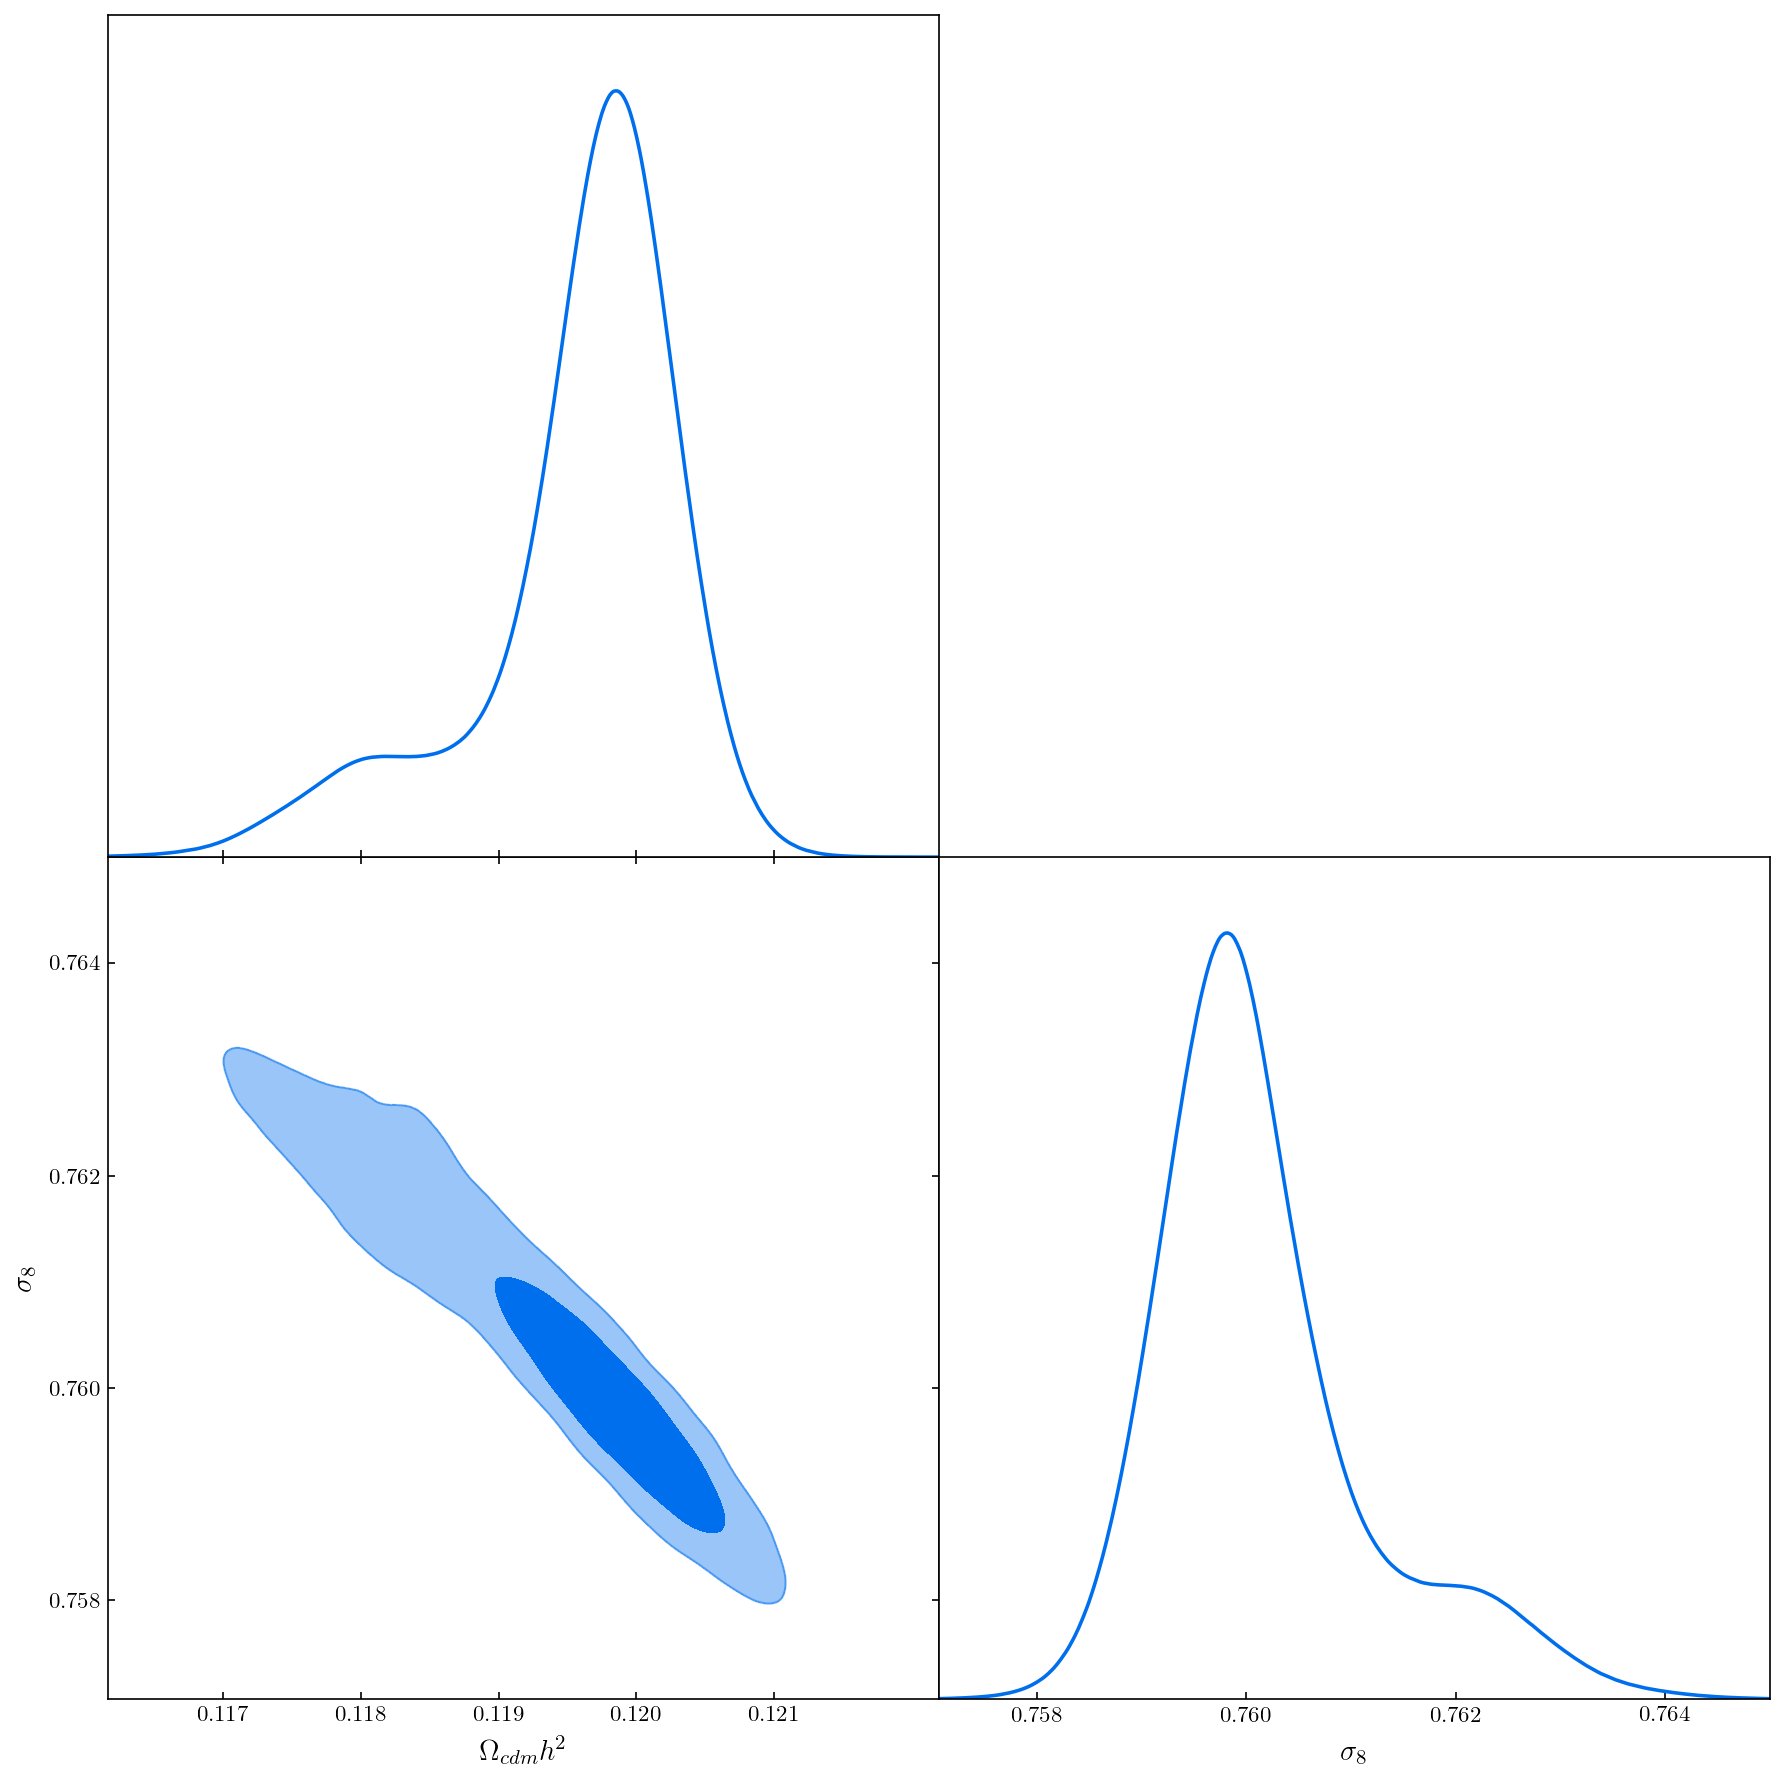

In [158]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(delfi_samples, filled_compare=True, normalized=True)

## As a check, compare DELFI posterior to a posterior from MCMC chain

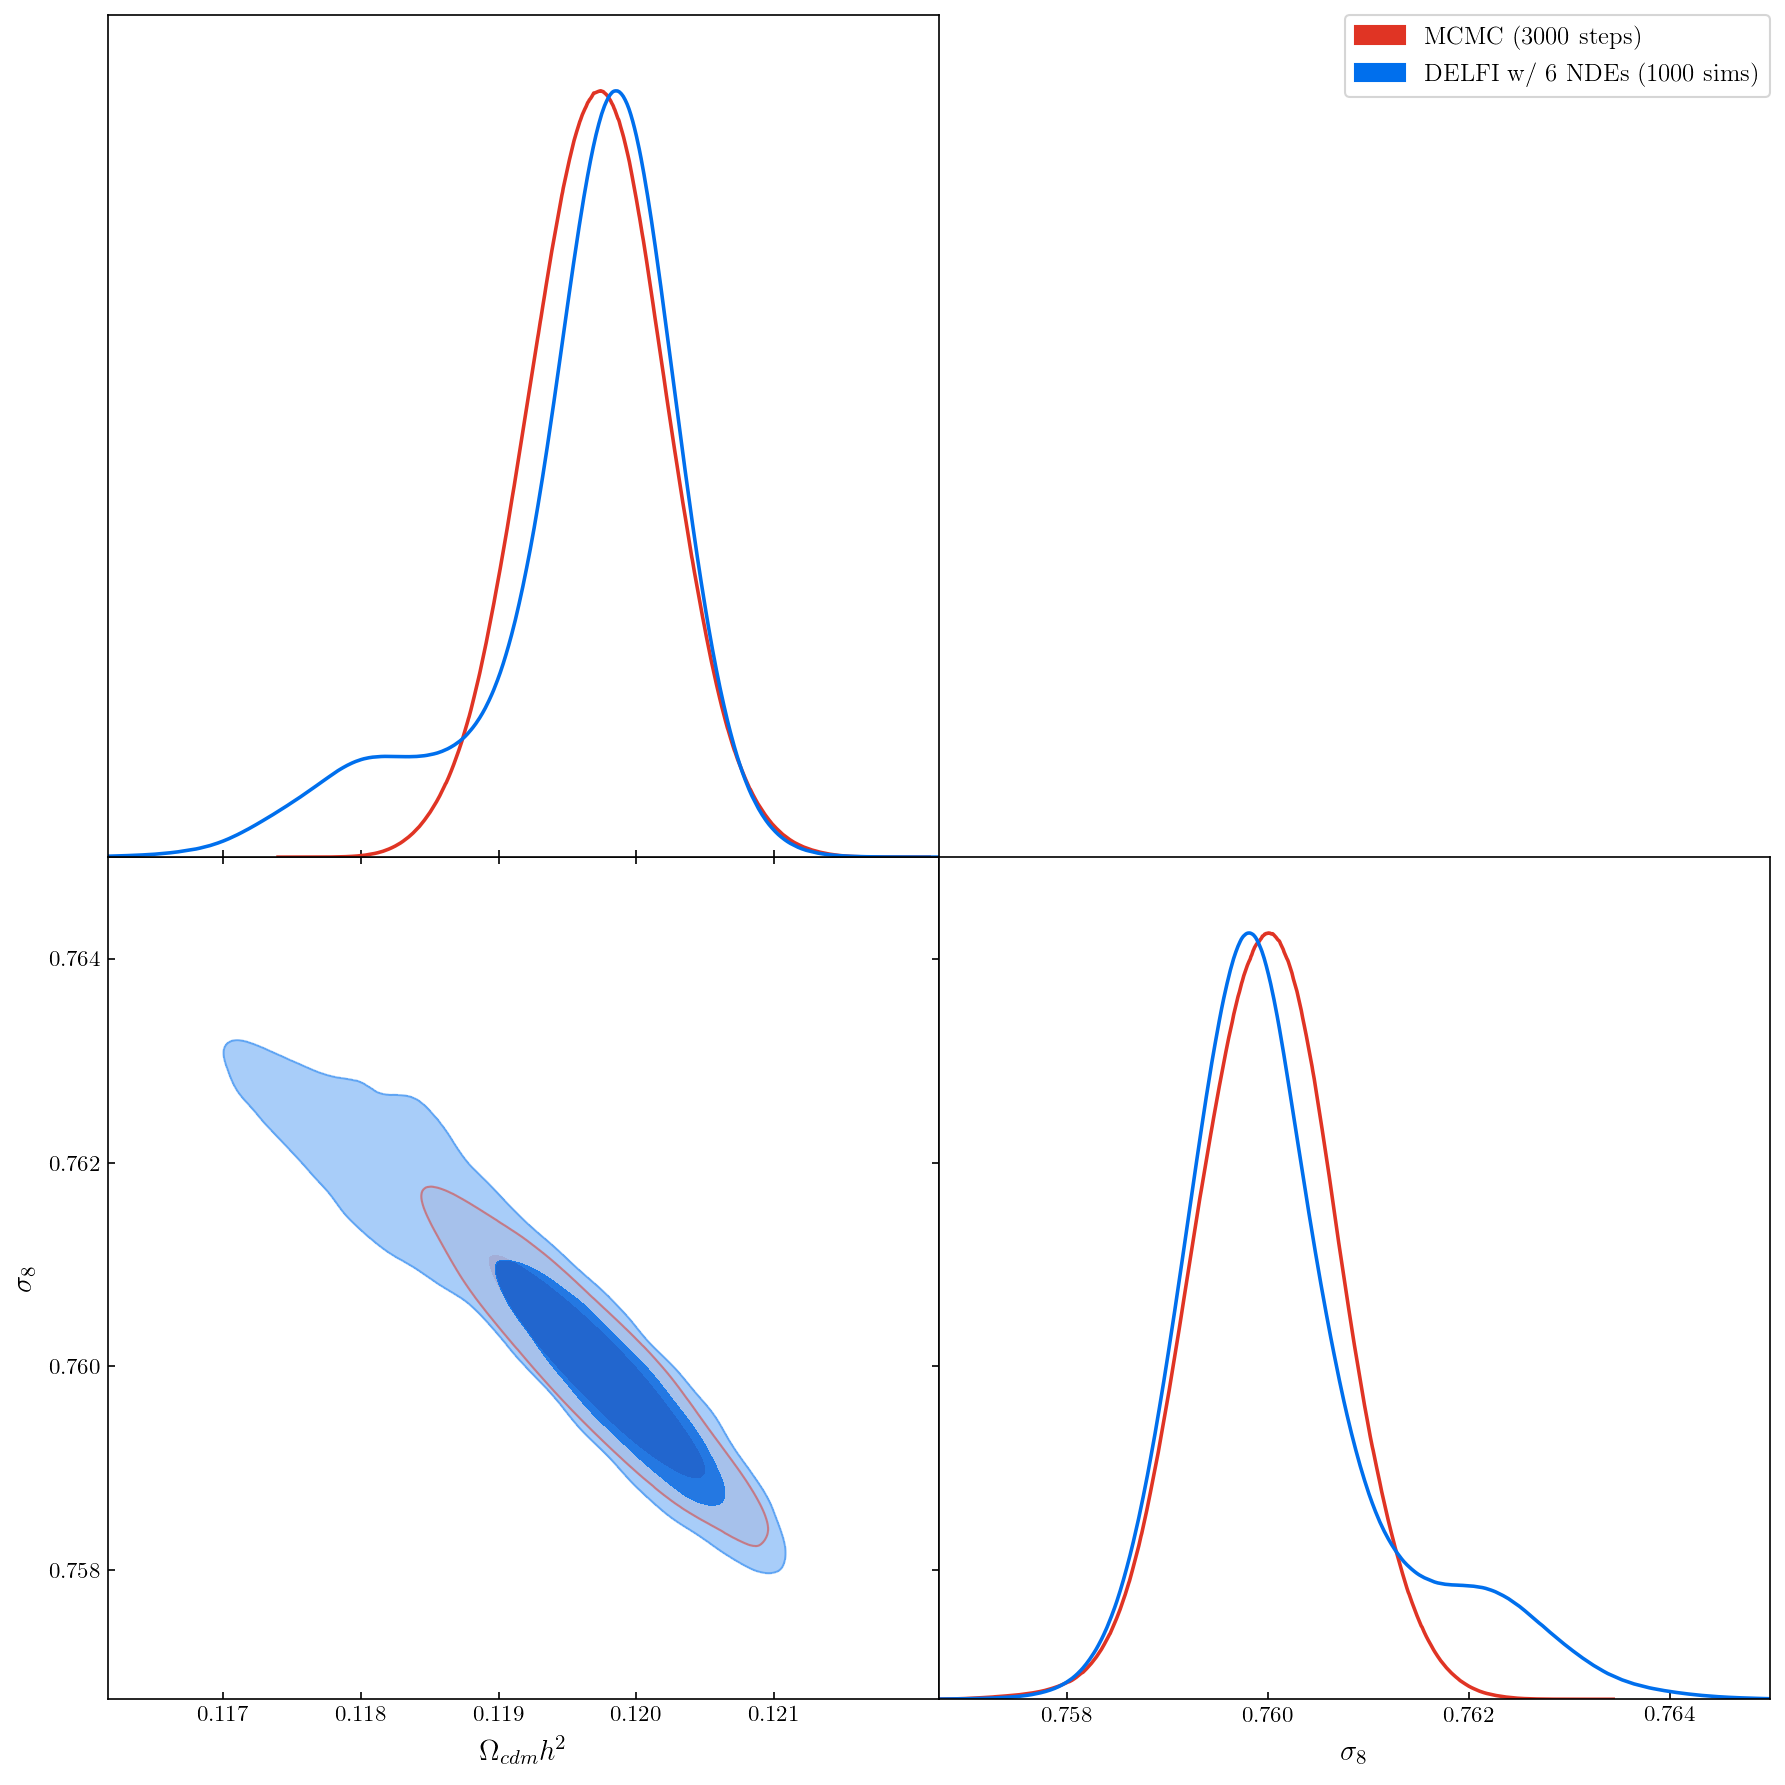

In [159]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples[0], delfi_samples[0]], 
                legend_labels = ['MCMC (3000 steps)','DELFI w/ 6 NDEs (1000 sims)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

#### Results from simulated data (seed = 1)

In [139]:
# +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_CMAFs_3000/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_CMAFs_3000/posterior_weights.npy')

# +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_CMAFs/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_CMAFs/posterior_weights.npy')

# an okay example + 
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_seed1_1000sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_seed1_1000sims/posterior_weights.npy')

# +
#posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_seed1_6NDEs_1000sims/posterior_samples.npy')
#posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_seed1_6NDEs_1000sims/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_seed1_1000init_3NDEs/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_seed1_1000init_3NDEs/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_3NDEs/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_3NDEs/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_disposable_sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_disposable_sims/posterior_weights.npy')

posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_3NDEs_8000sims/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_seed1_fisher_trial_3NDEs_8000sims/posterior_weights.npy')


In [140]:
samples = [posterior_samples]
weights = [posterior_weights]
delfi_samples_s = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


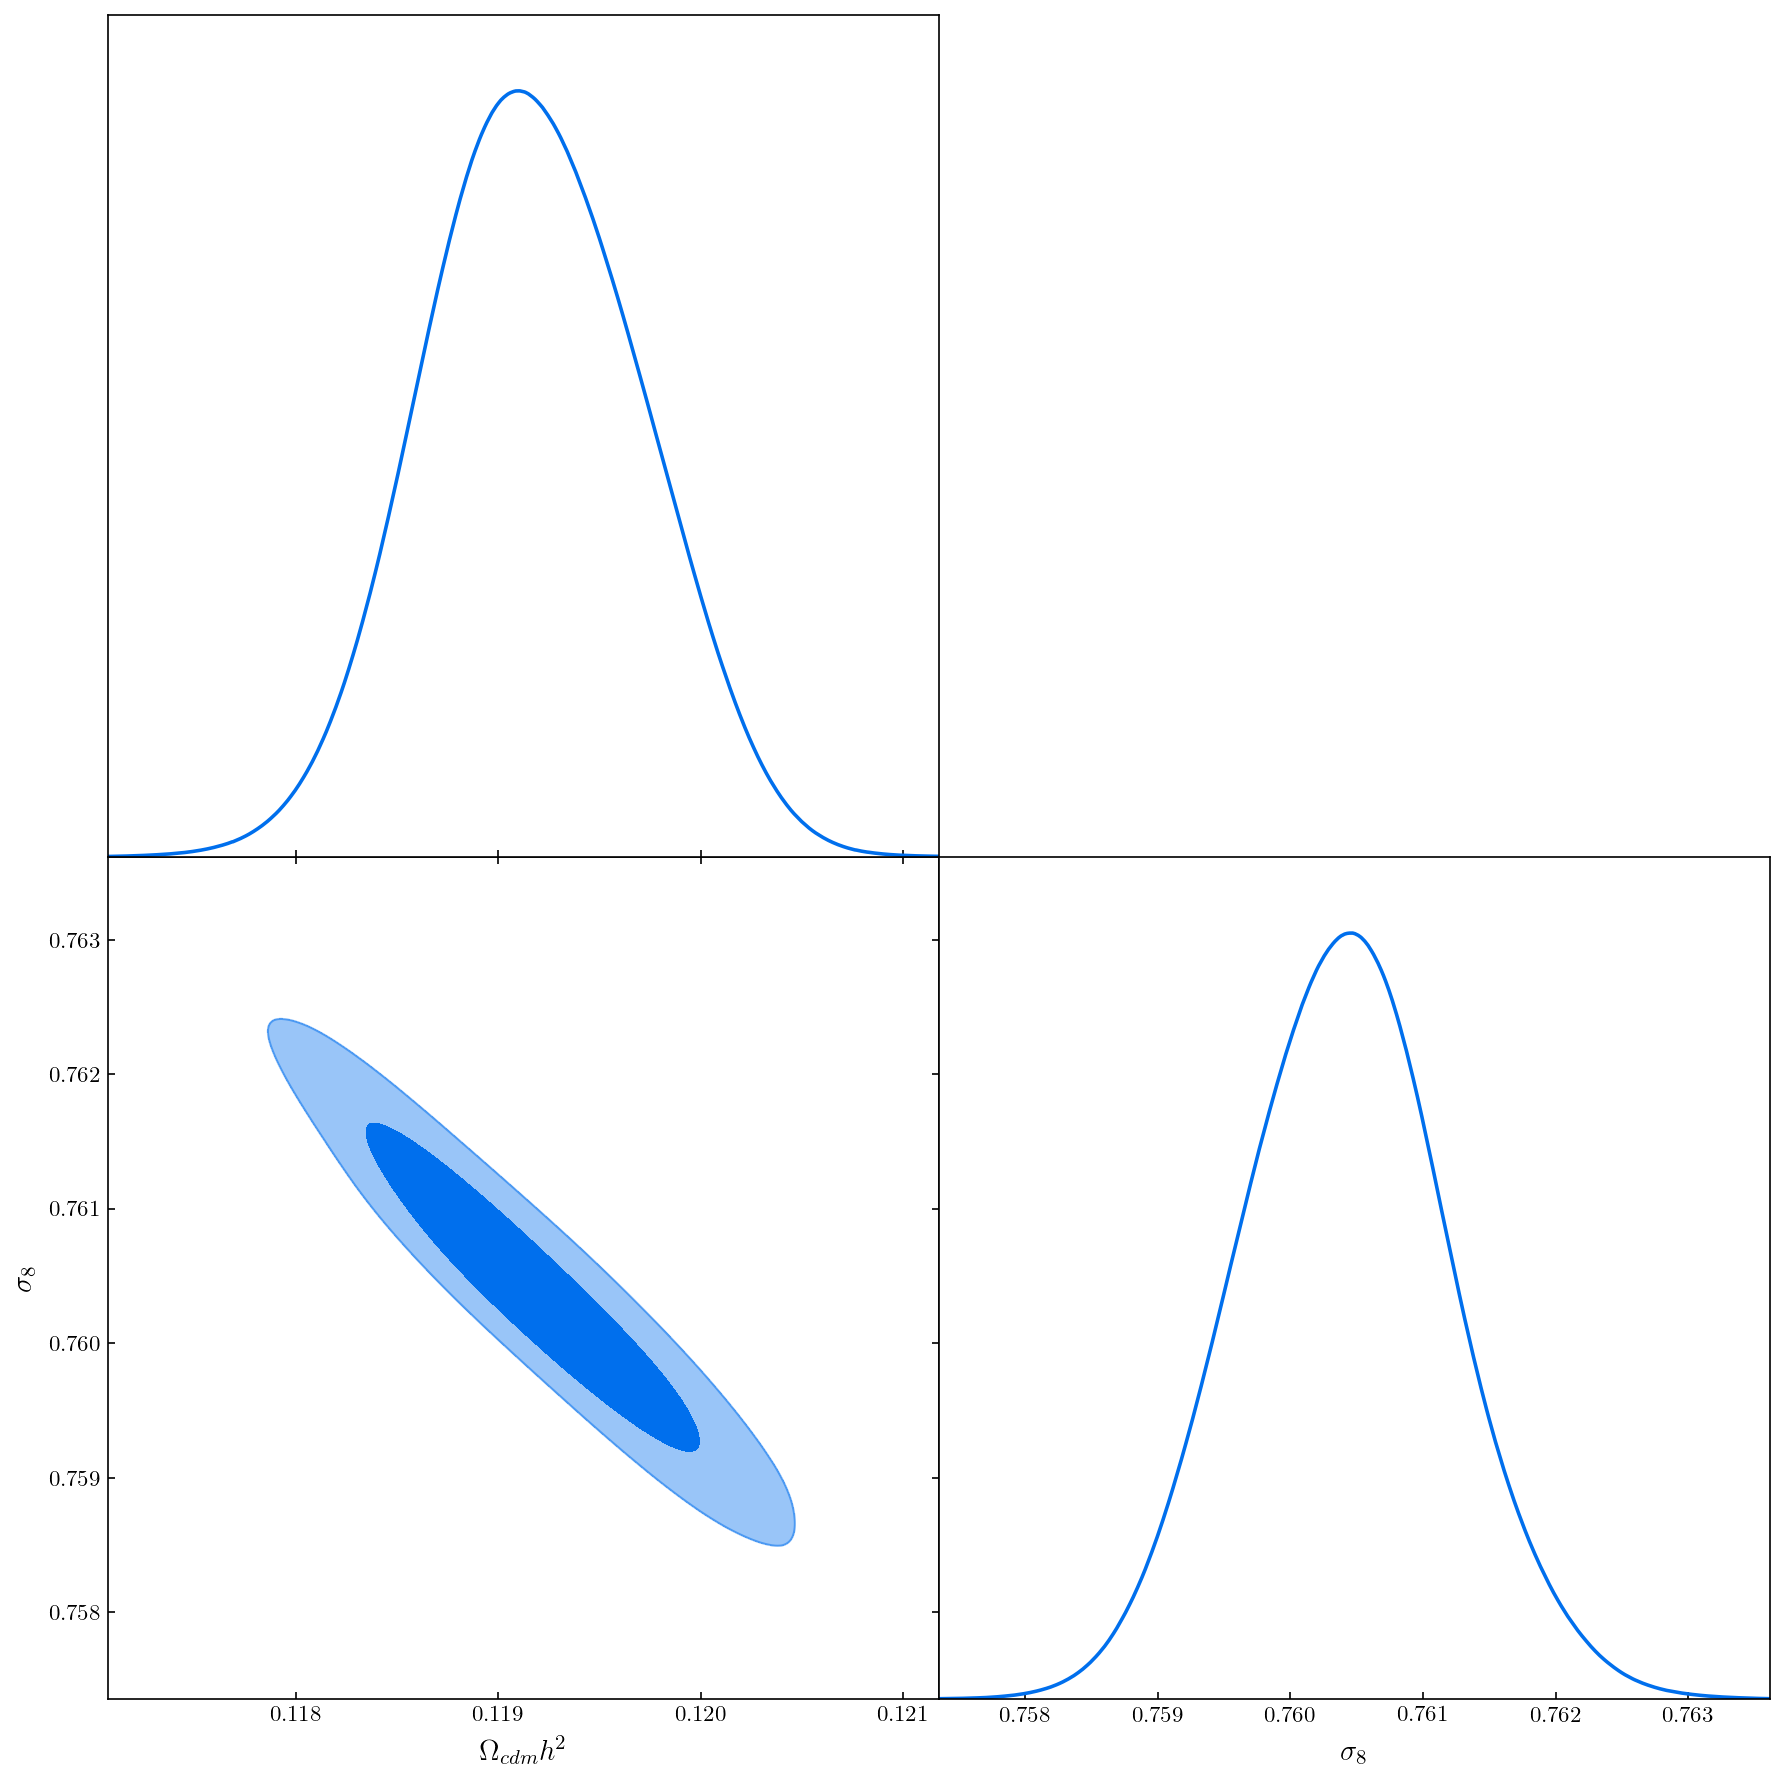

In [141]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(delfi_samples_s, filled_compare=True, normalized=True)

In [142]:
flat_samples = np.load('flat_samples_1000_seed1.npy')
flat_samples = [flat_samples]

In [143]:
mcmc_samples_s = [MCSamples(samples=s, 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(flat_samples)]

Removed no burn in


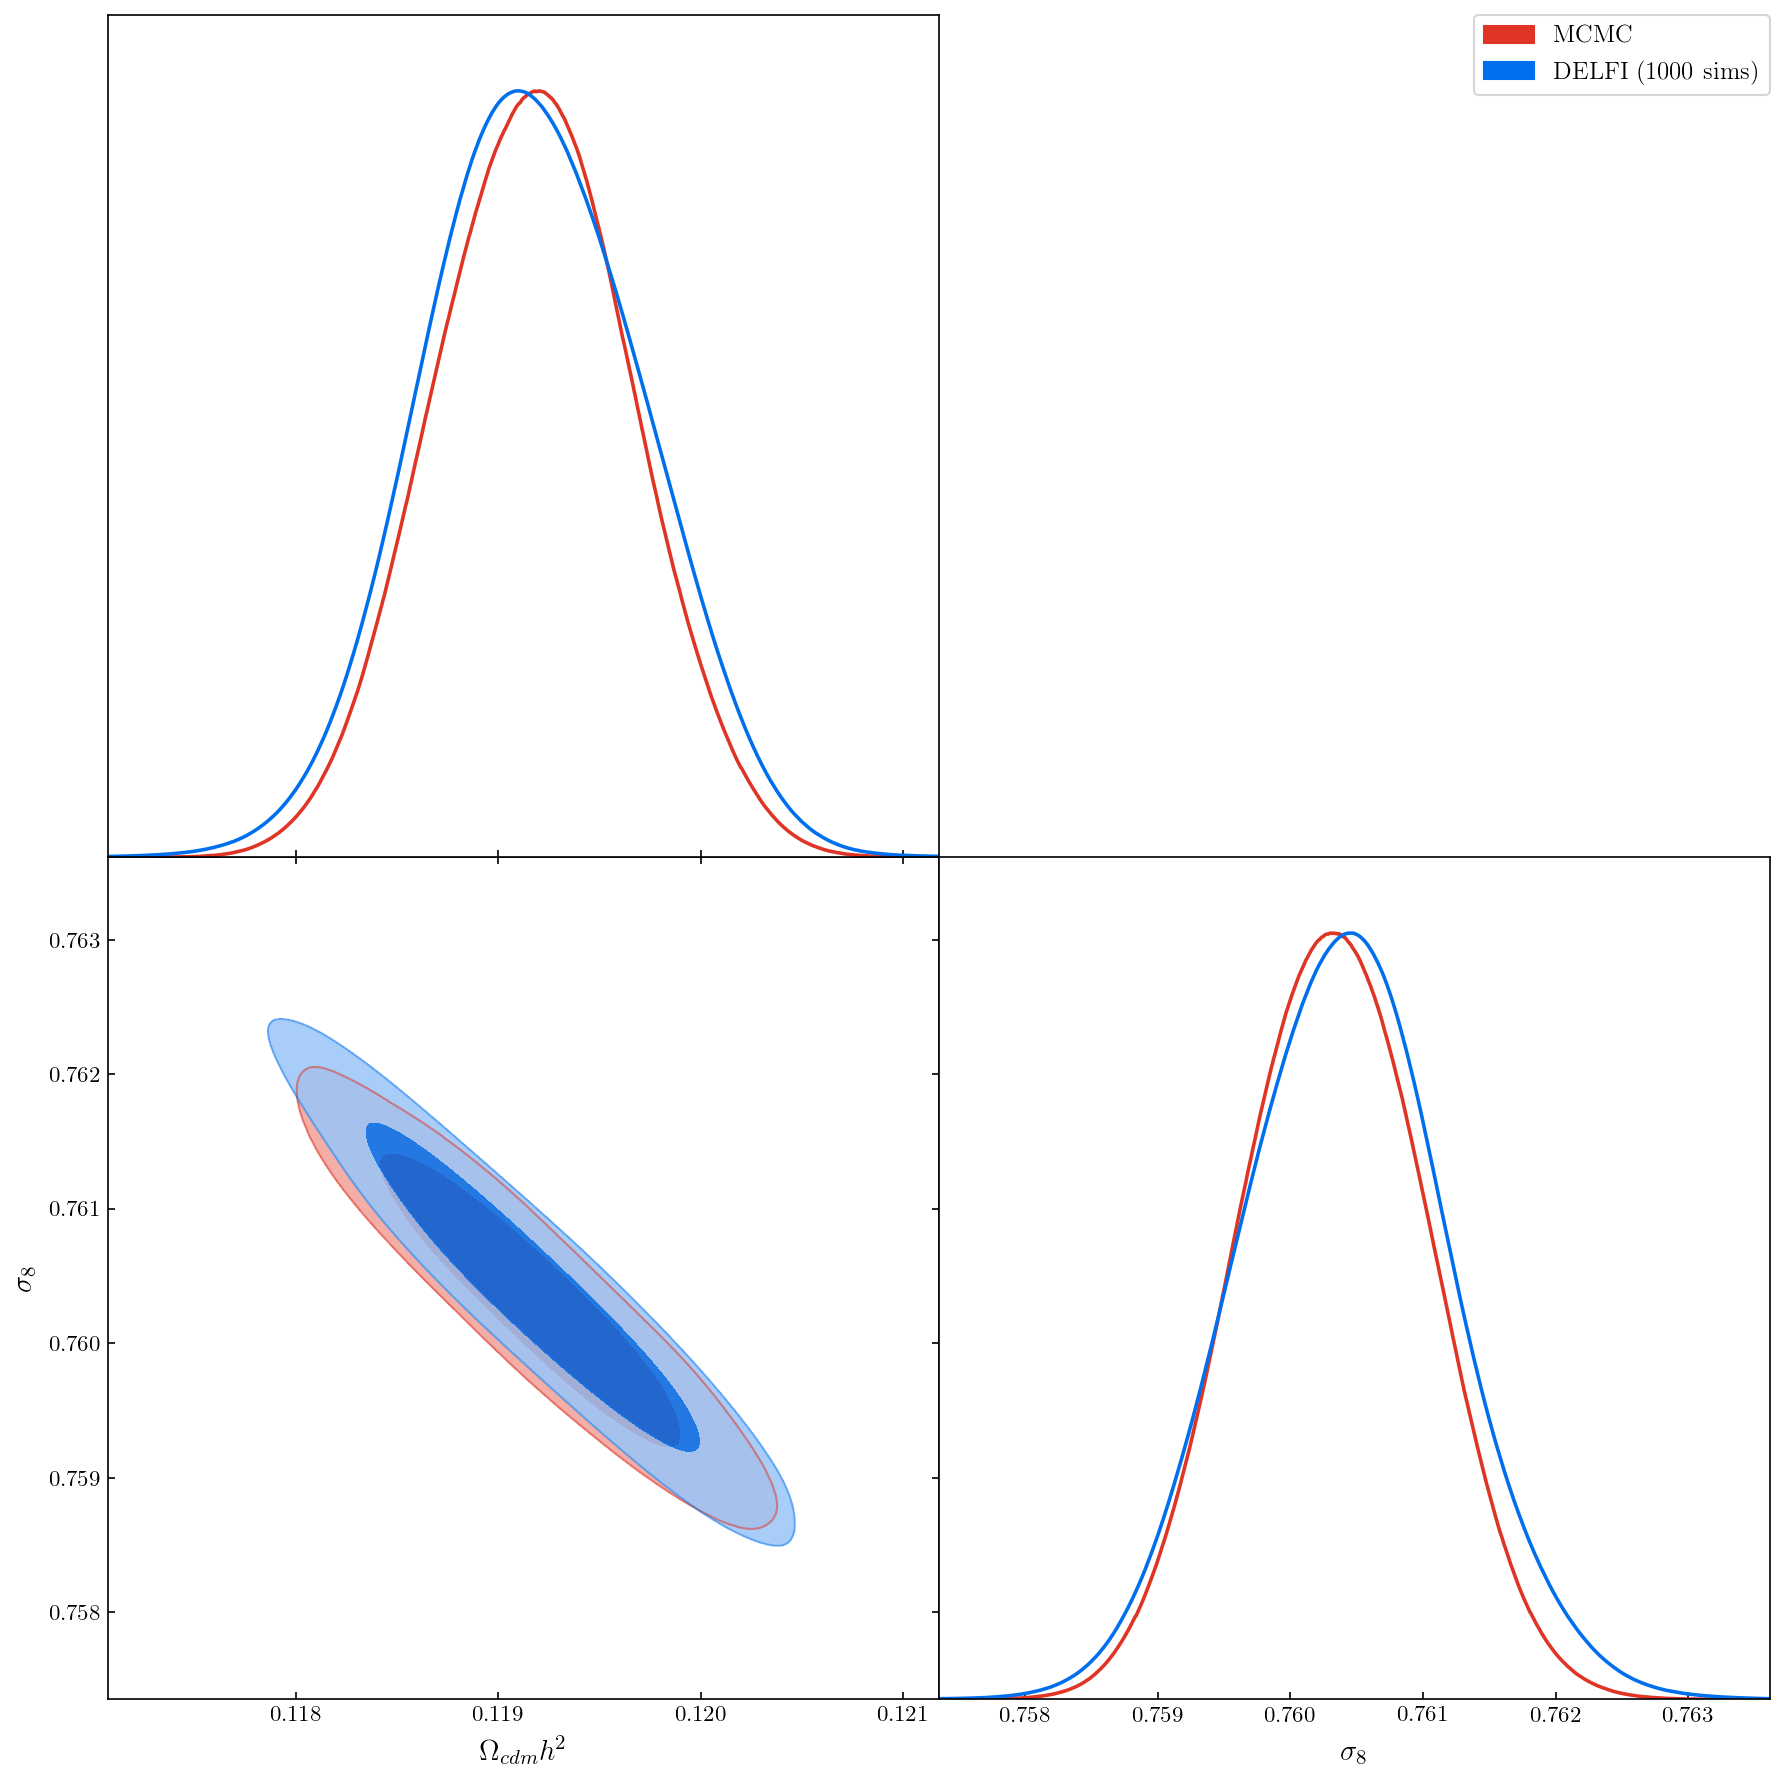

In [144]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples_s[0]], 
                legend_labels = ['MCMC','DELFI (1000 sims)'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

## Results with fisher-pretraining

### Fiducial

In [87]:
posterior_samples_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_pretraining_fiducial/posterior_samples.npy')
posterior_weights_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_pretraining_fiducial/posterior_weights.npy')


#posterior_samples_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_10populations_fiducial/posterior_samples.npy')
#posterior_weights_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_10populations_fiducial/posterior_weights.npy')


#posterior_samples_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_20populations_fiducial/posterior_samples.npy')
#posterior_weights_fisher_f = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_20populations_fiducial/posterior_weights.npy')


In [88]:
samples = [posterior_samples_fisher_f]
weights = [posterior_weights_fisher_f]
delfi_samples_fisher_f = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


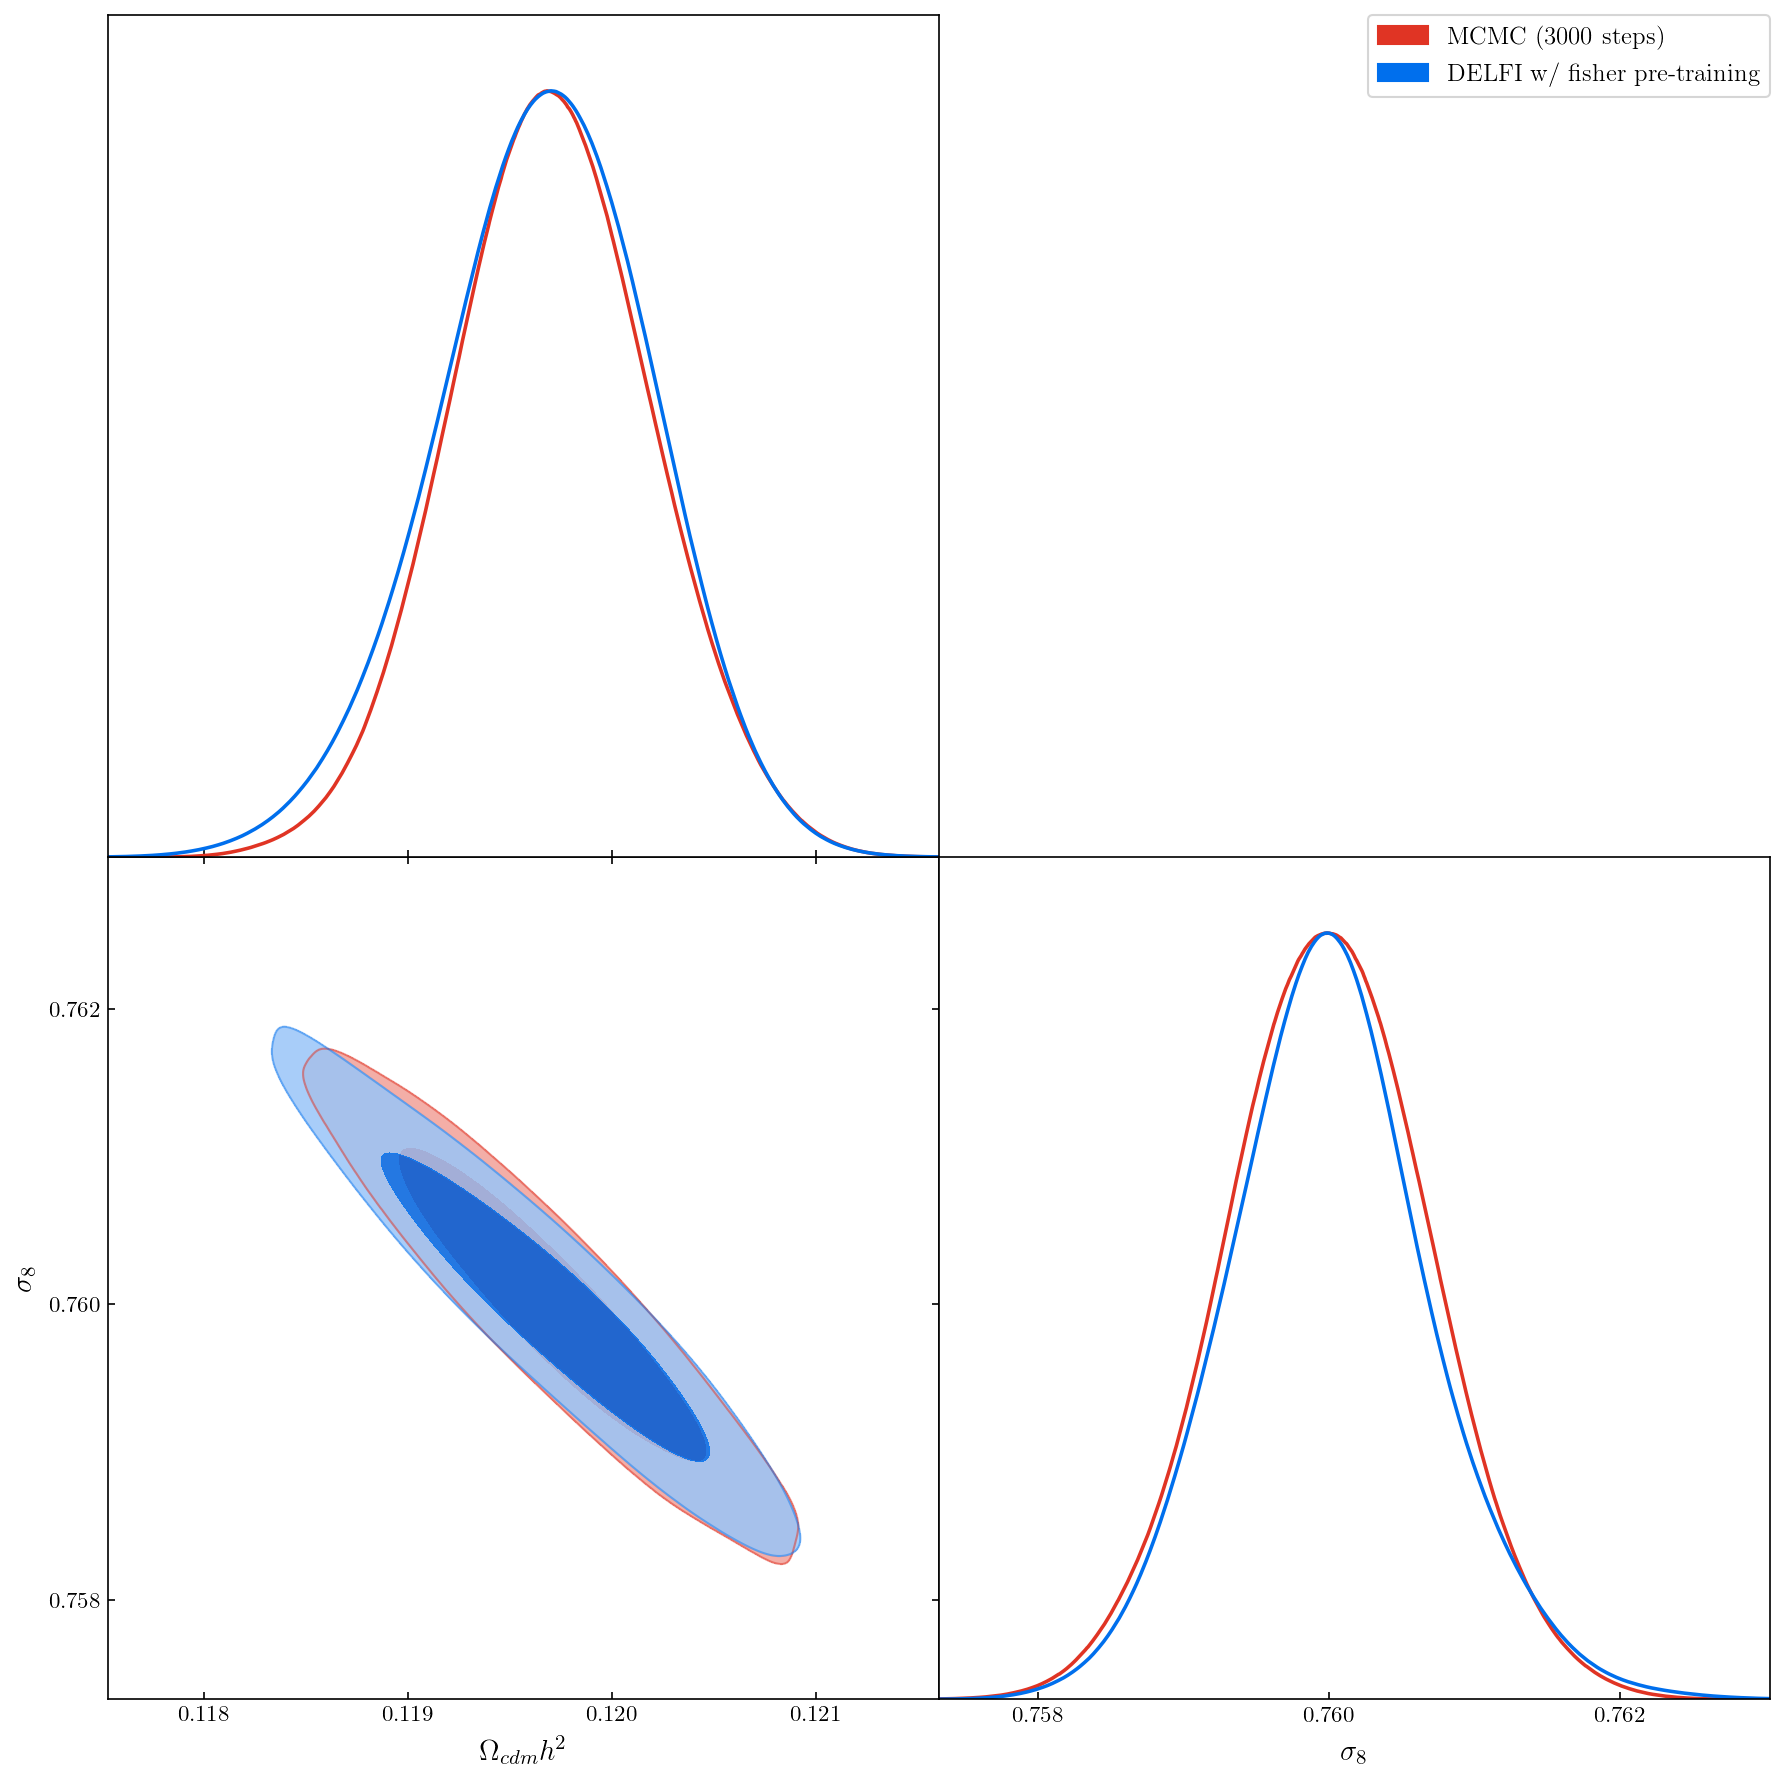

In [89]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples[0], delfi_samples_fisher_f[0]], 
                legend_labels = ['MCMC (3000 steps)','DELFI w/ fisher pre-training'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

### Skewed

In [90]:
posterior_samples_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_pretraining/posterior_samples.npy')
posterior_weights_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_pretraining/posterior_weights.npy')

#posterior_samples_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_10populations/posterior_samples.npy')
#posterior_weights_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes_10populations/posterior_weights.npy')

#posterior_samples_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes/posterior_samples.npy')
#posterior_weights_fisher_s = np.loadtxt('simulators/mass_function_n_counts/results/results_tinker_2params_fisher_6ndes/posterior_weights.npy')

In [91]:
samples = [posterior_samples_fisher_s]
weights = [posterior_weights_fisher_s]
delfi_samples_fisher_s = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1118, 0.1222], '\\sigma_{8}': [0.755, 0.765]}) 
                        #ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


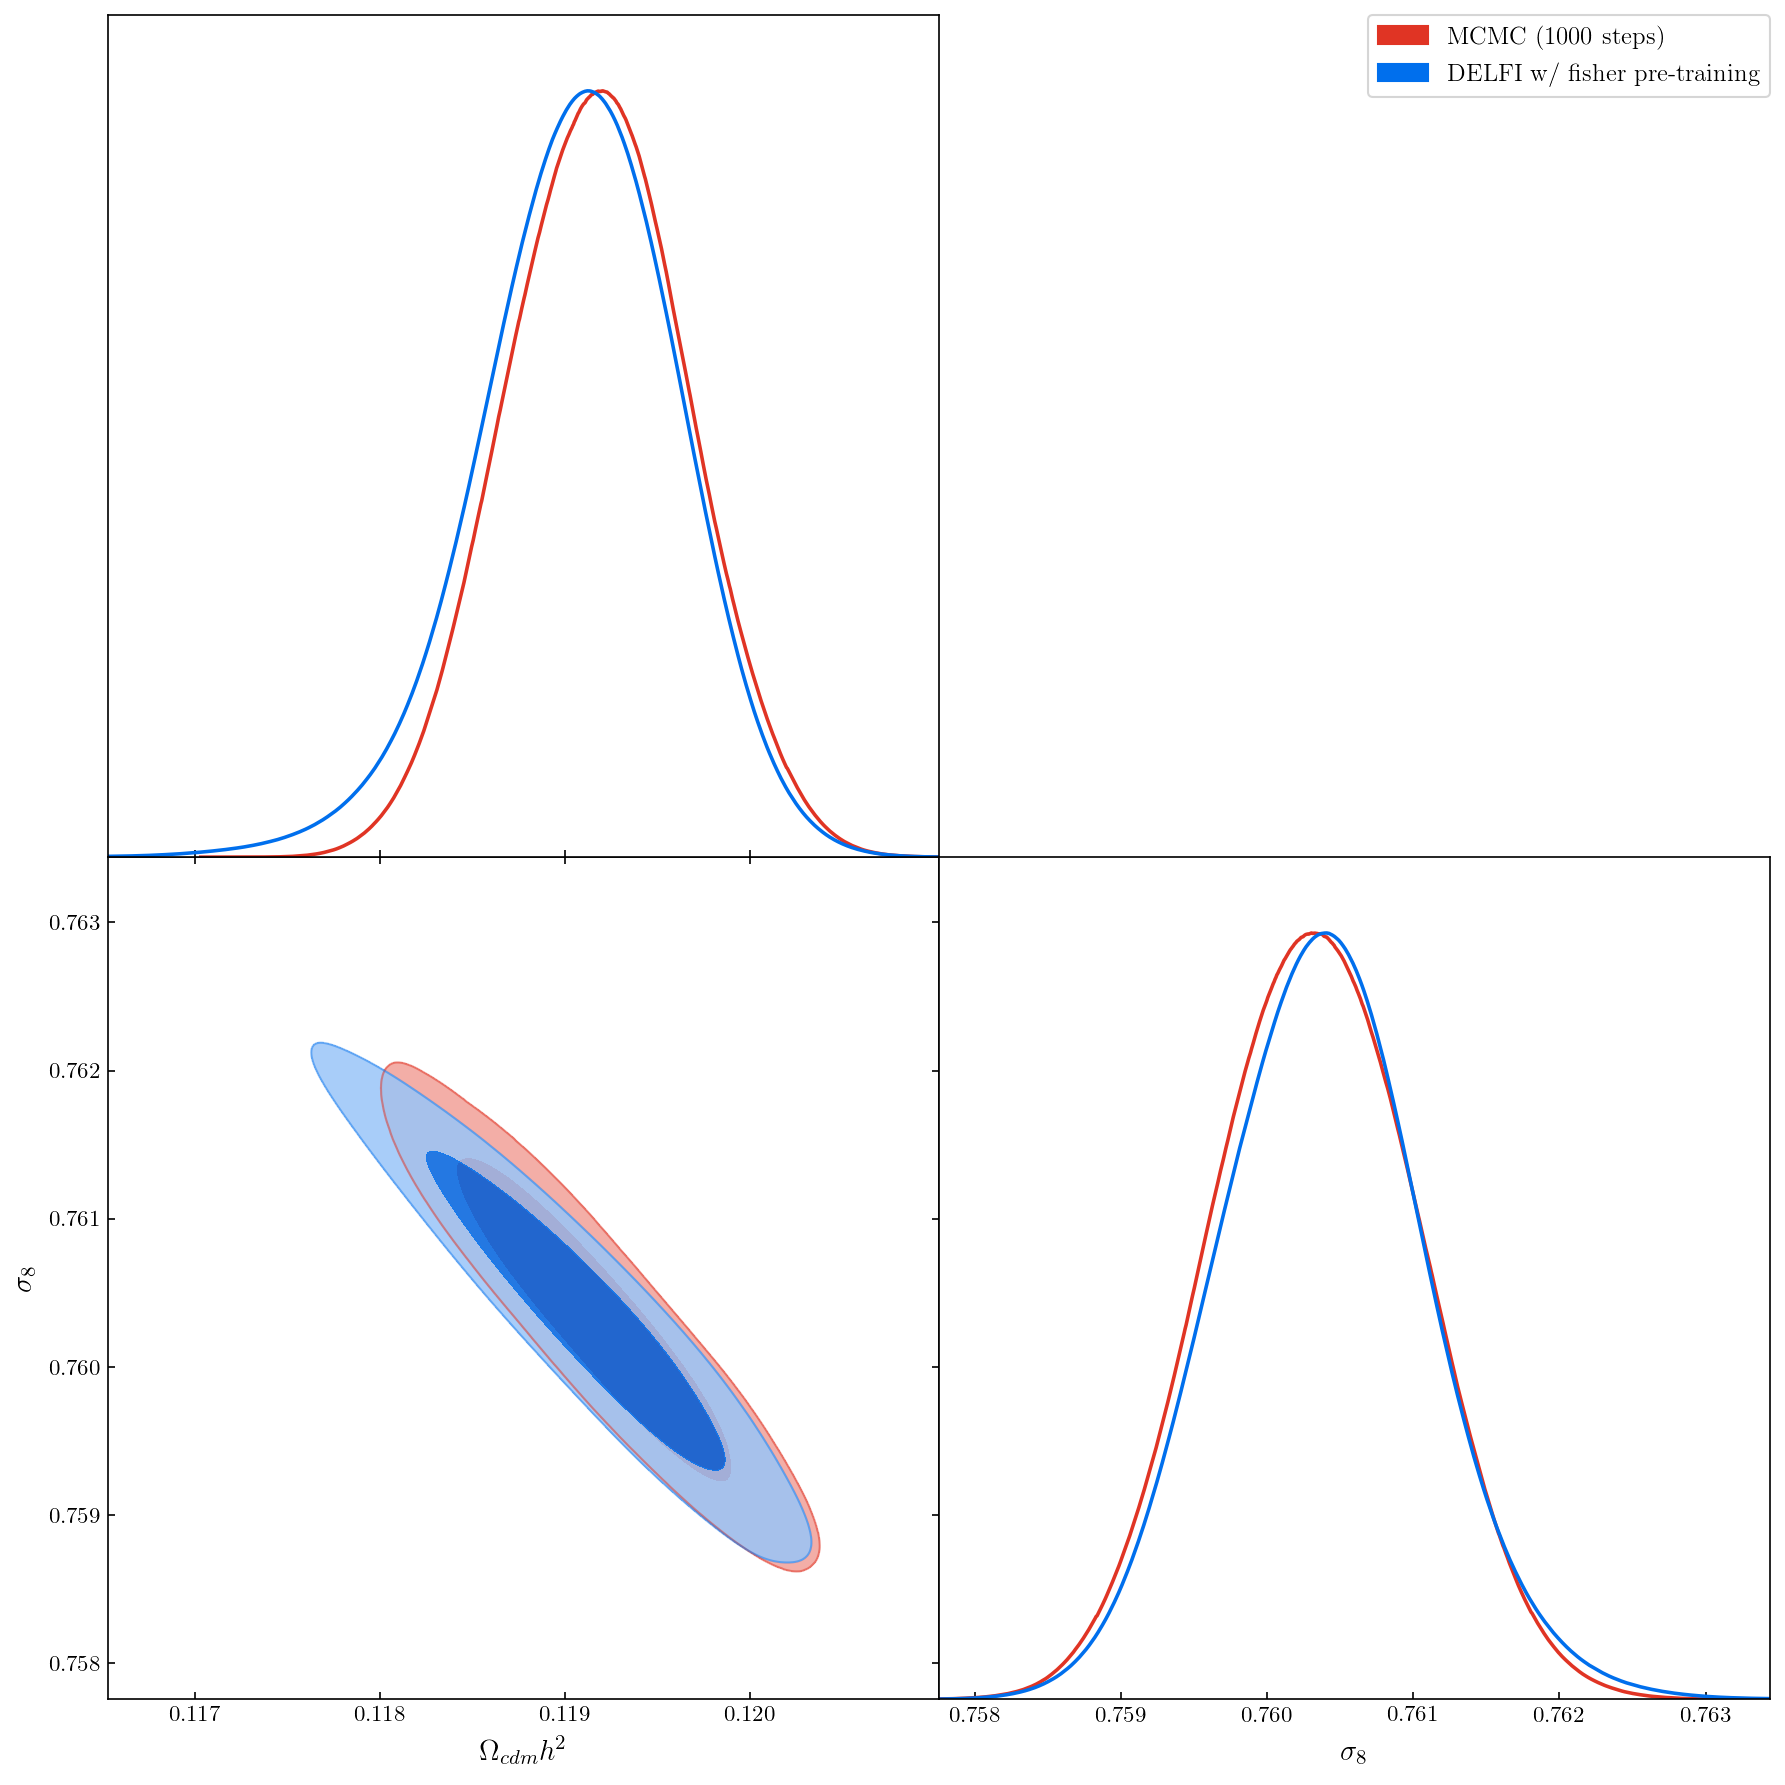

In [92]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot([mcmc_samples_s[0], delfi_samples_fisher_s[0]], 
                legend_labels = ['MCMC (1000 steps)','DELFI w/ fisher pre-training'],
                legend_loc = 'upper right',
                filled_compare=True, normalized=True)

In [140]:
posterior_samples_temp = posterior_samples
posterior_weights_temp = posterior_weights

In [141]:
posterior_samples_cdm = posterior_samples_temp[:, 0]
posterior_samples_sigma8 = posterior_samples_temp[:, 1]

In [142]:
indices1 = np.where(posterior_samples_cdm < 0.118)
indices2 = np.where(posterior_samples_cdm > 0.122)
indices_temp1 = np.concatenate((indices1[0], indices2[0]))

In [143]:
indices1 = np.where(posterior_samples_sigma8 > 0.765)
indices2 = np.where(posterior_samples_sigma8 < 0.755)
indices_temp2 = np.concatenate((indices1[0], indices2[0]))

In [144]:
indices = np.concatenate((indices_temp1, indices_temp2))

In [145]:
indices.shape

(1008,)

In [146]:
indices_unique = np.unique(indices)
indices_unique.shape

(697,)

In [147]:
posterior_samples_temp = np.delete(posterior_samples_temp, indices_unique, axis = 0)
posterior_weights_temp = np.delete(posterior_weights_temp, indices_unique, axis = 0)

In [148]:
import corner

In [ ]:
corner.corner()

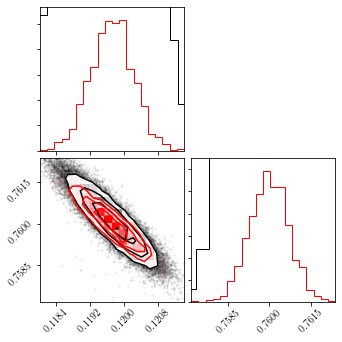

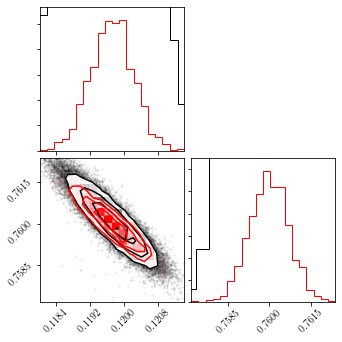

In [161]:
fig = corner.corner(posterior_samples_temp, weights = posterior_weights_temp)
corner.corner(flat_samples[0], fig=fig, color = 'red')

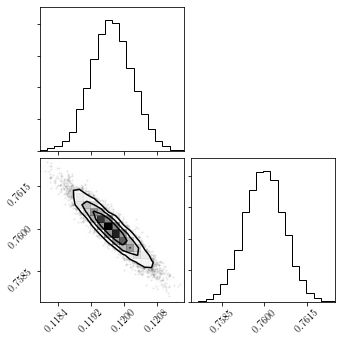

In [68]:
fig = corner.corner(flat_samples[0])

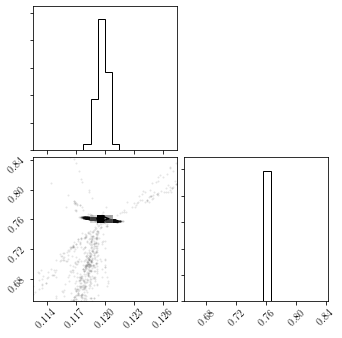

In [97]:
fig = corner.corner(posterior_samples, weights = posterior_weights)

In [63]:
axes = np.array(fig.axes).reshape((2, 2))
ax = axes[0, 0]
ax.set_xlim(0.118, 0.122)
ax.set_ylim(0.755, 0.765)

fig.show()

In [57]:
fig.show()

In [96]:
posterior_samples = np.delete(posterior_samples, indices, axis = 0)
posterior_weights = np.delete(posterior_weights, indices, axis = 0)

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.
/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


In [93]:
posterior_samples_cdm = posterior_samples[:, 0]

In [94]:
indices1 = np.where(posterior_samples_cdm < 0.118)
indices2 = np.where(posterior_samples_cdm > 0.112)

In [95]:
indices = np.concatenate((indices1[0], indices2[0])).shape

In [87]:
indices1 = np.where(posterior_samples_sigma8 > 0.77)
indices2 = np.where(posterior_samples_sigma8 < 0.75)

In [ ]:
def weighted_params(posterior_samples, posterior_weights):
    results_means = np.average(posterior_samples, axis =0, weights = posterior_weights)
    
    # https://stats.stackexchange.com/questions/6534/how-do-i-calculate-a-weighted-standard-deviation-in-excel
    M_nonzero = len(np.nonzero(posterior_weights)[0])
    numerator = np.sum(((posterior_samples - results_means)**2)*posterior_weights.reshape((posterior_samples.shape[0], 1)), axis = 0)
    denominator = (M_nonzero-1)*np.sum(posterior_weights)/M_nonzero
    
    results_stdev = np.sqrt(numerator/denominator)
    
    return results_means, results_stdev

In [ ]:
results_means_0, results_stdev_0 = weighted_params(posterior_samples_0, posterior_weights_0)
print('fiducial params' + str(theta_fiducial))
print(results_means_0)
print(results_stdev_0)

In [ ]:
print('Upper and lower 2\sigma-limits:')
print('On \omega_cdm: [' + str((results_means_0 - 2*results_stdev_0)[0]) + ', ' + str((results_means_0 + 2*results_stdev_0)[0]), ']')
print('On \sigma_8: [' + str((results_means_0 - 2*results_stdev_0)[1]) + ', ' + str((results_means_0 + 2*results_stdev_0)[1]), ']')


In [ ]:
np.savetxt(DelfiEnsemble0.results_dir+'posterior_samples.npy', posterior_samples_0)
np.savetxt(DelfiEnsemble0.results_dir+'posterior_weights.npy', posterior_weights_0)

In [ ]:
DelfiEnsemble0.results_dir